# FrozenPy example script

## Import necessary packages

In [3]:
# Import essential modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

path = '/Users/home/Documents/Jupyter/my-modules/FrozenPy'
os.chdir(path)
import FrozenPy as fp

# Plot formatting
%matplotlib inline                    
sns.set(style="ticks", color_codes=True)

## 1. Load data

In [4]:
# load metadata
metadata_dir = '/Users/home/Documents/Jupyter/my-modules/FrozenPy/Examples/Conditioning'
Metadata_df = fp.read_metadata(metadata_dir, sep=',')


# make new .raw.csv from .out files
Cond_dir = '/Users/home/Documents/Jupyter/my-modules/FrozenPy/Examples/Conditioning'
fp.read_out(Cond_dir)

# load data from .raw.csv
os.chdir(Cond_dir)
Cond_S1 = fp.read_rawcsv('20200323 - CRH IED - Cond - Sq 1.raw.csv')
Cond_S2 = fp.read_rawcsv('20200323 - CRH IED - Cond - Sq 2.raw.csv')
Cond_S3 = fp.read_rawcsv('20200323 - CRH IED - Cond - Sq 3.raw.csv')

Metadata from CRH_IED.metadata.csv successfully loaded
Saved 20200323 - CRH IED - Cond - Sq 2.raw.csv!
Saved 20200323 - CRH IED - Cond - Sq 3.raw.csv!
Saved 20200323 - CRH IED - Cond - Sq 1.raw.csv!
Done!
Dropped "DELETE" columns in 20200323 - CRH IED - Cond - Sq 1.raw.csv
Dropped "DELETE" columns in 20200323 - CRH IED - Cond - Sq 2.raw.csv
Dropped "DELETE" columns in 20200323 - CRH IED - Cond - Sq 3.raw.csv


## 2. Detect freezing from threshold

In [5]:
# Freezing to Threshold
Cond_Sq1_df = fp.detect_freezing(Cond_S1)
Cond_Sq2_df = fp.detect_freezing(Cond_S2)
Cond_Sq3_df = fp.detect_freezing(Cond_S3)

# Concatenate all squad dataframes
Cond_df = pd.concat([Cond_Sq1_df, Cond_Sq2_df, Cond_Sq3_df], axis=1)

## 3. Slice data 

In [6]:
# slice data
BL_df, Trials_df = fp.get_averagedslices(df=Cond_df,
                                         BL=180,
                                         CS=10,
                                         US=2,
                                         Trials=5,
                                         ISI=58,
                                         fs=5,
                                         Behav='Freezing')
Trials_df.head()

,ID,Trial,CS,US,ISI
0,CRH7,1,10.0,0.0,16.896552
1,CRH12,1,0.0,0.0,5.517241
2,CRH17,1,12.0,0.0,12.758621
3,CRH1,1,0.0,0.0,0.000000
4,CRH13,1,0.0,0.0,4.137931


## 4. Merge metadata and plot

In [7]:
# merge metadata and data
BL_md_df = pd.merge(Metadata_df, BL_df, on='ID', copy='True')
Trials_md_df = pd.merge(Metadata_df, Trials_df, on='ID', copy='True')

Trials_md_df.head()

,ID,Genotype,Sex,Trial,CS,US,ISI
0,CRH1,Cre+,Male,1,0.0,0.0,0.000000
1,CRH1,Cre+,Male,2,30.0,10.0,2.413793
2,CRH1,Cre+,Male,3,20.0,0.0,10.344828
3,CRH1,Cre+,Male,4,12.0,50.0,15.517241
4,CRH1,Cre+,Male,5,80.0,40.0,26.206897


Text(0, 0.5, '% Freezing')

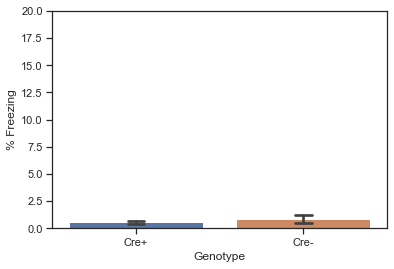

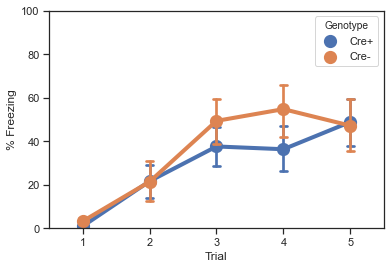

In [8]:
# baseline
plt.figure()
sns.barplot(data=BL_md_df, x='Genotype', y='BL', ci=68, capsize=.1)
plt.ylim(0, 20)
plt.ylabel('% Freezing')


# trials
plt.figure()
sns.pointplot(data=Trials_md_df,
                x='Trial', y='CS', hue='Genotype',
                scale=1.5, ci=68, capsize=.1)
plt.ylim(0, 100)
plt.ylabel('% Freezing')

## 5. Stats

In [9]:
# Compute a two-way mixed-design ANOVA
aov = pg.mixed_anova(data=Trials_md_df,
                     dv='CS', within='Trial', between='Genotype',
                     subject='ID')
pg.print_table(aov)


ANOVA SUMMARY

Source              SS    DF1    DF2        MS       F    p-unc    np2  eps
-----------  ---------  -----  -----  --------  ------  -------  -----  -----
Genotype       977.455      1     19   977.455   0.443    0.514  0.023  -
Trial        32924.571      4     76  8231.143  13.329    0.000  0.412  0.821
Interaction   1570.919      4     76   392.730   0.636    0.638  0.032  -



## 6. Convert to wide format

In [10]:
# Long
Trials_md_df.head()

,ID,Genotype,Sex,Trial,CS,US,ISI
0,CRH1,Cre+,Male,1,0.0,0.0,0.000000
1,CRH1,Cre+,Male,2,30.0,10.0,2.413793
2,CRH1,Cre+,Male,3,20.0,0.0,10.344828
3,CRH1,Cre+,Male,4,12.0,50.0,15.517241
4,CRH1,Cre+,Male,5,80.0,40.0,26.206897


In [11]:
# Pivot long to wide
Trials_wide = Trials_md_df.pivot_table(index=['ID', 'Sex', 'Genotype'],
                                       columns='Trial',
                                       values=['CS', 'US', 'ISI'])
# wide
Trials_wide.head()

CS                                ISI             \
Trial                    1     2     3     4     5          1          2   
ID    Sex    Genotype                                                      
CRH1  Male   Cre+      0.0  30.0  20.0  12.0  80.0   0.000000   2.413793   
CRH10 Female Cre+      0.0  44.0  50.0  10.0  10.0  12.758621  14.827586   
CRH11 Female Cre+      0.0   0.0   0.0   0.0   0.0   0.000000   0.000000   
CRH12 Male   Cre-      0.0   0.0  10.0  38.0   0.0   5.517241  15.172414   
CRH13 Male   Cre-      0.0  14.0  46.0  80.0  64.0   4.137931  40.344828   

                                                         US                    \
Trial                          3          4          5    1     2     3     4   
ID    Sex    Genotype                                                           
CRH1  Male   Cre+      10.344828  15.517241  26.206897  0.0  10.0   0.0  50.0   
CRH10 Female Cre+       8.620690   1.724138  20.689655  0.0   0.0  20.0   0.0   
CRH11 Female Cre+       0.000000   0.000000   4.827586  0.0   0.0   0.0   0.0   
CRH12 Male   Cre-       8.620690  25.517241  38.965517  0.0   0.0   0.0   0.0   
CRH13 Male   Cre-      33.103448  43.448276  49.310345  0.0  10.0   0.0  30.0   

                             
Trial                     5  
ID    Sex    Genotype        
CRH1  Male   Cre+      40.0  
CRH10 Female Cre+       0.0  
CRH11 Female Cre+       0.0  
CRH12 Male   Cre-      70.0  
CRH13 Male   Cre-      30.0